In [123]:
import numpy as np
from os import listdir
from os.path import isfile, join
import tifffile
from cellpose import models, io, core
import time
from sklearn.model_selection import train_test_split
from statistics import mean
from u_net import UNet
import torch
import torch.nn as nn
import torch.nn.functional as F

#import data function
def get_files(path,normalise=False,remove_txt=False):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

    if remove_txt:
        onlyfiles = [val for val in onlyfiles if not val.endswith(".txt")]

    onlyfiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    #if num_imgs > len(onlyfiles): num_imgs = len(onlyfiles)
    files = [np.squeeze(tifffile.imread(path +  onlyfiles[i])) for i in range(len(onlyfiles))]
    
    if normalise:
        files = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in files]
    
    return files
    
def get_data(path, set='01',normalise_images=True):

    if len(set) == 2: #set 01 or set 02
        images_path = path + set + '/'
        images = get_files(images_path,normalise=normalise_images)
        masks_path = path + set + '_GT/TRA/'
        masks = get_files(masks_path,remove_txt=True)
    elif set == '0102': #both sets
        images_path = path + '01/'
        images_01 = get_files(images_path,normalise=normalise_images)
        images_path = path + '02/'
        images_02 = get_files(images_path,normalise=normalise_images)
        images = images_01 + images_02

        masks_path = path + '01_GT/TRA/'
        masks_01 = get_files(masks_path,remove_txt=True)
        masks_path = path + '02_GT/TRA/'
        masks_02 = get_files(masks_path,remove_txt=True)
        masks = masks_01 + masks_02
    else:
        images = []
        masks = []

    return images, masks

#get cellpose predictions
def get_cellpose_predictions(model,images,binary=True):
    logger = io.logger_setup()
    predictions = model.eval(images, batch_size=1, channels=[0,0], diameter=model.diam_labels)[0]
    if binary:
        predictions = [np.where(mask>0,1,0) for mask in predictions]
    return predictions

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, activation_fn, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = activation_fn(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        inputs_binary = torch.where(inputs>0.5,1.0,0.0)
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  

        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

def train_epoch(model, train_loader, test_loader, loss_fn, activation_fn, optimiser):
    model.train()

    #get train loss
    #total_train_loss_per_epoch = 0
    for i, (x, y) in enumerate(train_loader):
        #x = x.copy()
        #y = y.copy()
        #print(i)
        #x = x.type(torch.float32)
        #y = y.type(torch.float32)
        (x,y) = (x.to('cuda:0'), y.to('cuda:0')) # sending the data to the device (cpu or GPU)

        x = x.unsqueeze(1)
        pred = model(x)# make a prediction

        loss = loss_fn(pred, y, activation_fn) # calculate the loss of that prediction
    
        optimiser.zero_grad() # zero out the accumulated gradients
        loss.backward() # backpropagate the loss
        optimiser.step() # update model parameters

        
        #total_train_loss_per_epoch += loss.detach().item()

    #total_train_loss_per_epoch /= len(train_loader)
   
    #get test loss
    #total_test_loss_per_epoch = 0
    total_dice = 0
    with torch.no_grad():
        for images, cellprobs in test_loader:
            #images = images.copy()
            #cellprobs = cellprobs.copy()
            
            images = images.to('cuda:0')
            cellprobs = cellprobs.to('cuda:0')

            images = torch.unsqueeze(images,1)
            cellprobs = torch.unsqueeze(cellprobs,1)
            #cellprobs = cellprobs.to(torch.float32)
            outputs = model(images)

            #outputs = activation_fn(outputs)
            loss = loss_fn(outputs, cellprobs, activation_fn)
            #total_test_loss_per_epoch += loss.item()

            #calculate dice score
            outputs = activation_fn(outputs)
            outputs = torch.where(outputs>0.5,1.0,0.0)
            outputs = outputs.view(-1)
            cellprobs = cellprobs.view(-1)
            intersection = (outputs * cellprobs).sum()  
            dice = (2.*intersection+1)/(outputs.sum() + cellprobs.sum()+1)  
            total_dice += dice
            
    #total_test_loss_per_epoch /= len(test_loader)
    total_dice /= len(test_loader)
    #total_dice = total_dice.item()
    return total_dice

In [145]:
#import the 02 images and masks
images, masks = get_data("c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\" + 'datasets/Fluo-N2DH-GOWT1/', set = '0102',normalise_images=True)
#images, masks = get_data("/Users/rehanzuberi/Downloads/distillCellSegTrack/" + 'datasets/Fluo-N2DL-HeLa/',num_imgs=92)
#split the images and masks into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)
print('split data')

#make the cellpose model predict on the X_train and X_test images
cellpose_model = models.CellposeModel(gpu=core.use_gpu(), pretrained_model="c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\segmentation\\train_dir\\models\\cellpose_trained_model_GOWT1_2")
y_train_cp = get_cellpose_predictions(cellpose_model,X_train,binary=True)
y_test_cp = get_cellpose_predictions(cellpose_model,X_test,binary=True)
print('got cellpose predictions')

split data
2023-05-03 20:13:14,641 [INFO] ** TORCH CUDA version installed and working. **
2023-05-03 20:13:14,642 [INFO] >>>> loading model c:\Users\rz200\Documents\development\distillCellSegTrack\segmentation\train_dir\models\cellpose_trained_model_GOWT1_2
2023-05-03 20:13:14,642 [INFO] ** TORCH CUDA version installed and working. **
2023-05-03 20:13:14,643 [INFO] >>>> using GPU
2023-05-03 20:13:14,912 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2023-05-03 20:13:14,913 [INFO] >>>> model diam_labels =  45.370 (mean diameter of training ROIs)
creating new log file
2023-05-03 20:13:14,915 [INFO] WRITING LOG OUTPUT TO C:\Users\rz200\.cellpose\run.log
2023-05-03 20:13:14,915 [INFO] 
cellpose version: 	2.2 
platform:       	win32 
python version: 	3.8.16 
torch version:  	1.12.0+cu113
2023-05-03 20:14:46,194 [INFO] 100%|##########| 147/147 [01:31<00:00,  1.61it/s]
creating new log file
2023-05-03 20:14:46,651 [INFO] WRITING LOG OUTPUT TO C:\Users\rz200

In [146]:
print(len(X_train))

147


In [147]:
import torchvision
from torchvision import transforms

import torchvision.transforms.functional as TF
import random
    
for i in range(len(X_train)):
    X_train.append(np.rot90(X_train[i],1))
    X_train.append(np.rot90(X_train[i],2))
    X_train.append(np.rot90(X_train[i],3))

    y_train_cp.append(np.rot90(y_train_cp[i],1))
    y_train_cp.append(np.rot90(y_train_cp[i],2))
    y_train_cp.append(np.rot90(y_train_cp[i],3))


In [148]:
print(len(X_train))


588


In [149]:
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, image, mask):
        self.image = image
        self.mask = mask

    def __len__(self):
        return len(self.mask)

    def __getitem__(self, idx):
        img = self.image[idx]
        label = self.mask[idx]
        return img, label

In [150]:
X_train_torch = [torch.from_numpy(np.array(X_train[i])) for i in range(len(X_train))]
y_train_cp_torch = [torch.from_numpy(np.array(y_train_cp[i])).type(torch.float32) for i in range(len(y_train_cp))]
X_test_torch = [torch.from_numpy(np.array(X_test[i])) for i in range(len(X_test))]
y_test_cp_torch = [torch.from_numpy(np.array(y_test_cp[i])).type(torch.float32) for i in range(len(y_test_cp))]

In [151]:
train_dataset = ImageDataset(X_train_torch, y_train_cp_torch)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataset = ImageDataset(X_test_torch, y_test_cp_torch)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [152]:
#model
model = UNet()
model = model.to('cuda:0')

#model configurations
loss_fn = DiceBCELoss()
optimiser = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [153]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print(t,r,a,f)

17170956288 12580814848 1219057664 11361757184


In [89]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [142]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print(t,r,a,f)

17170956288 12580814848 1157193216 11423621632


In [154]:
print(len(X_train))

588


In [155]:
print('training')
dices_on_GPU = []
for epoch in range(10):
    start_time = time.time()
    dice = train_epoch(model, train_loader, test_loader, loss_fn, torch.sigmoid, optimiser)
    print('epoch: ', epoch, 'dice', dice, 'time: ', time.time()-start_time)
    dices_on_GPU.append(dice)

training
epoch:  0 dice tensor(0.6508, device='cuda:0') time:  188.79261875152588
epoch:  1 dice tensor(0.6778, device='cuda:0') time:  143.1783471107483
epoch:  2 dice tensor(0.8786, device='cuda:0') time:  78.32241129875183
epoch:  3 dice tensor(0.8850, device='cuda:0') time:  87.93572926521301
epoch:  4 dice tensor(0.8942, device='cuda:0') time:  80.49293971061707
epoch:  5 dice tensor(0.8980, device='cuda:0') time:  77.45217275619507
epoch:  6 dice tensor(0.8816, device='cuda:0') time:  78.57302904129028
epoch:  7 dice tensor(0.8984, device='cuda:0') time:  81.12100052833557
epoch:  8 dice tensor(0.9012, device='cuda:0') time:  79.54413986206055
epoch:  9 dice tensor(0.8997, device='cuda:0') time:  80.0072374343872


In [156]:
torch.save(model.state_dict(), 'c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\segmentation\\train_dir\\models\\distillation_model_GOWT1_3')

: 

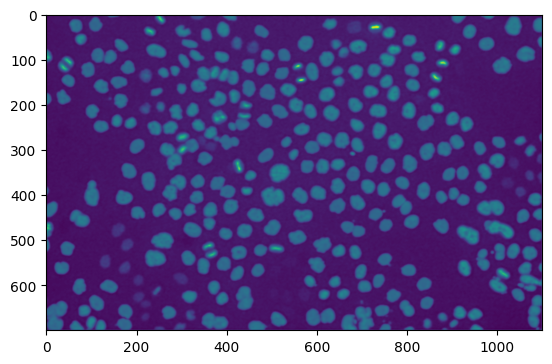

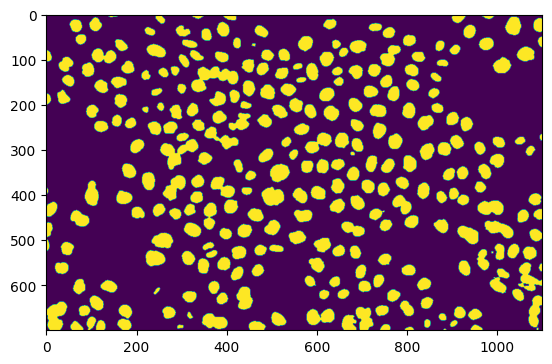

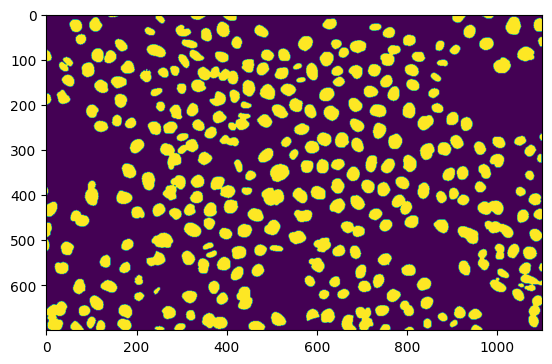

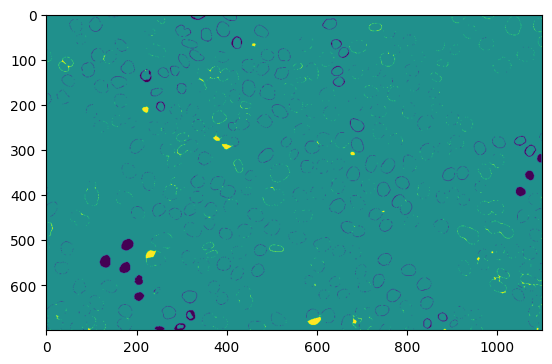

In [106]:
import matplotlib.pyplot as plt

pred = model(X_test_torch[0].unsqueeze(0).unsqueeze(0).to('cuda:0'))

plt.imshow(pred.detach().cpu().numpy().squeeze(0).squeeze(0))
plt.show()

pred = torch.sigmoid(pred)
pred = torch.where(pred>0.5,1.0,0.0)

plt.imshow(pred.detach().cpu().numpy().squeeze(0).squeeze(0))
plt.show()

plt.imshow(y_test_cp_torch[0].detach().cpu().numpy())
plt.show()

plt.imshow(pred.detach().cpu().numpy().squeeze(0).squeeze(0)-y_test_cp_torch[0].detach().cpu().numpy())
plt.show()



In [78]:
print(dices_on_GPU)

[tensor(0.1617, device='cuda:0'), tensor(0.8027, device='cuda:0'), tensor(0.8274, device='cuda:0'), tensor(0.8925, device='cuda:0'), tensor(0.8869, device='cuda:0'), tensor(0.9155, device='cuda:0'), tensor(0.9495, device='cuda:0'), tensor(0.9608, device='cuda:0'), tensor(0.9570, device='cuda:0'), tensor(0.9491, device='cuda:0')]


In [96]:
import cv2
from skimage import measure

def binary_to_instance_mask(binary_mask):
    #We first erode the mask to unconnect touching cell masks
    kernel = np.ones((5, 5), np.uint8)
    erosion = cv2.erode(binary_mask.astype('uint8'), kernel, iterations=1)

    #We then give a unique number to each cluster
    instances = measure.label(erosion, connectivity=2)

    #We calculate the center of each cluster
    cluster_centers = np.array([np.mean(np.where(instances == i), axis=1) for i in np.unique(instances) if i != 0])
    
    for i in range(len(binary_mask)):
        print(i)

        for j in range(len(binary_mask)):
            if binary_mask[i][j] == 1 and instances[i][j] == 0:
                distances = np.sqrt((cluster_centers[:,0] - i)**2 + (cluster_centers[:,1] - j)**2)
                instances[i][j] = np.unique(instances)[np.argmin(distances)+1]
                
    return instances

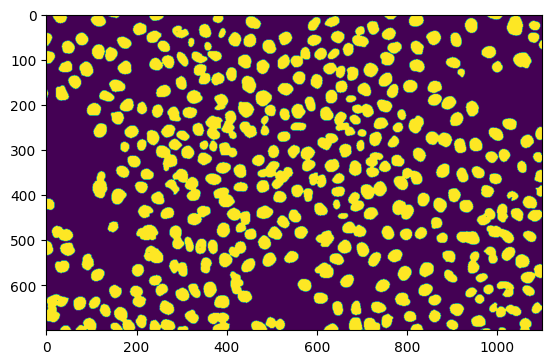

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

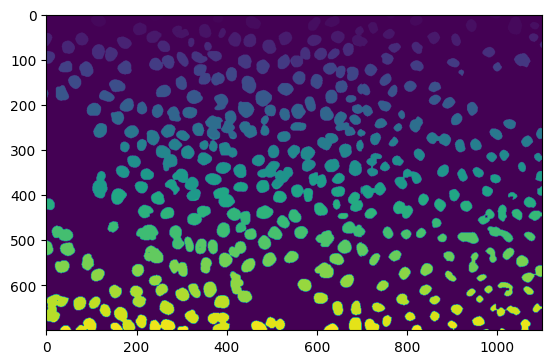

In [99]:
#get some groundtruth mask
import matplotlib.pyplot as plt
plt.imshow(y_train_cp[0])
plt.show()

instances = binary_to_instance_mask(y_train_cp[0])
plt.imshow(instances)
plt.show()

#binarise them

#apply cluster differentiating

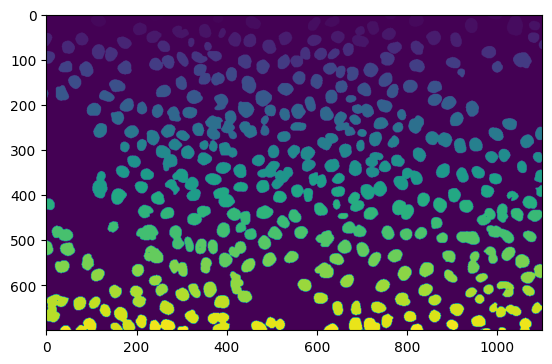

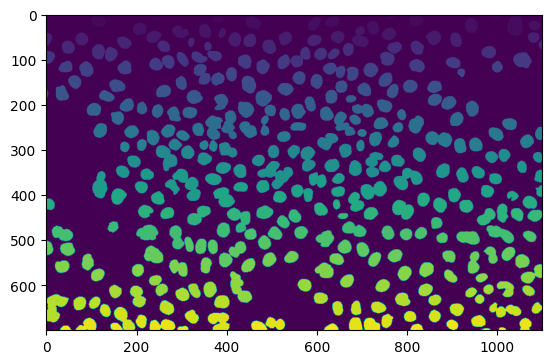

In [106]:
instances_2 = measure.label(y_train_cp[0], connectivity=2)
plt.imshow(instances_2)
plt.show()

instances_2 = measure.label(y_train_cp[0], connectivity=1)
plt.imshow(instances_2)
plt.show()

In [103]:
print(np.unique(instances == instances_2,return_counts=True))

(array([False,  True]), array([207553, 562447], dtype=int64))


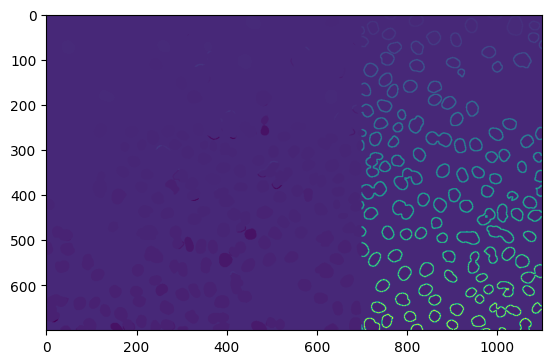

In [105]:
plt.imshow(instances_2-instances)

In [109]:
def get_IoU(predicted_masks,gt_masks):
    intersection_unions = []
    for i in range(len(predicted_masks)):
        intersection = np.logical_and(predicted_masks[i], gt_masks[i]).sum()
        union = np.logical_or(predicted_masks[i], gt_masks[i]).sum()
        intersection_unions.append(intersection/union)
    return mean(intersection_unions)

def get_dice(predicted_masks,gt_masks):
    dices = []
    for i in range(len(predicted_masks)):
        intersection = np.logical_and(predicted_masks[i], gt_masks[i]).sum()
        dice = (2*intersection)/(predicted_masks[i].sum() + gt_masks[i].sum())
        dices.append(dice)
    return mean(dices)


In [111]:
#import the trained model
model = UNet()
model = model.to('cuda:0')
model.load_state_dict(torch.load('c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\segmentation\\train_dir\\models\\unet_trained_model'))

#get predictions on test_cp
predicted_masks = []
for x in X_test:
    prediction = model(torch.unsqueeze(torch.from_numpy(np.array(x)),0).to('cuda:0').to(torch.float32).unsqueeze(1))
    prediction = torch.sigmoid(prediction)
    prediction = torch.where(prediction>0.5,1.0,0.0)
    prediction = prediction.squeeze(0).squeeze(0).cpu().detach().numpy()
    predicted_masks.append(prediction)

#make predictions on the test_cp and get the IoU and Dice scores
#get IoU and dice coeff
IoU = get_IoU(predicted_masks,y_test_cp)
dice = get_dice(predicted_masks,y_test_cp)
print('IoU: ', IoU)
print('Dice: ', dice)

IoU:  0.9354714736800913
Dice:  0.9666529620616084


In [118]:
preds = model(torch.from_numpy(np.array(X_test)).to('cuda:0').to(torch.float32).unsqueeze(1))

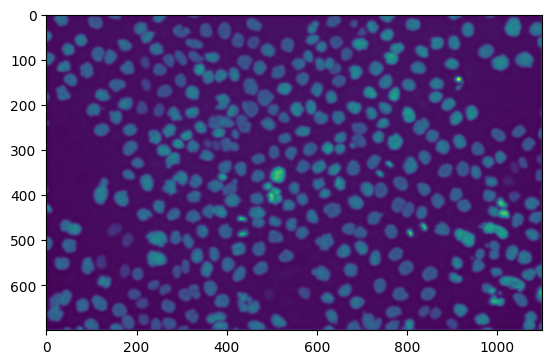

In [122]:
plt.imshow(preds[2].squeeze(0).squeeze(0).cpu().detach().numpy())

In [125]:
print(np.unique(preds[0].squeeze(0).squeeze(0).cpu().detach().numpy()))

[-9.239323 -9.209831 -9.206938 ... 48.46855  48.697002 48.837357]


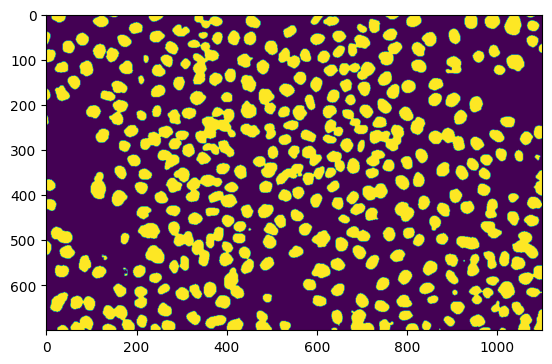

In [115]:
plt.imshow(predicted_masks[3])